# Designing experiment in Comet.ml.

### Import libraries

In [77]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Comet.ml settings

In [78]:
from comet_ml import Experiment

# Create an experiment with your API key
experiment = Experiment(
    api_key="4OsujUejimzi9clYAqYIzZ0sp",
    project_name="medical-appointment",
    workspace="pime-tuletorn",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pime-tuletorn/medical-appointment/6cf772251cb64f87bf847c4e8143e2ca



### Reading data

In [79]:
df = pd.read_csv('data/KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Visualization

#### Numeric features distribution

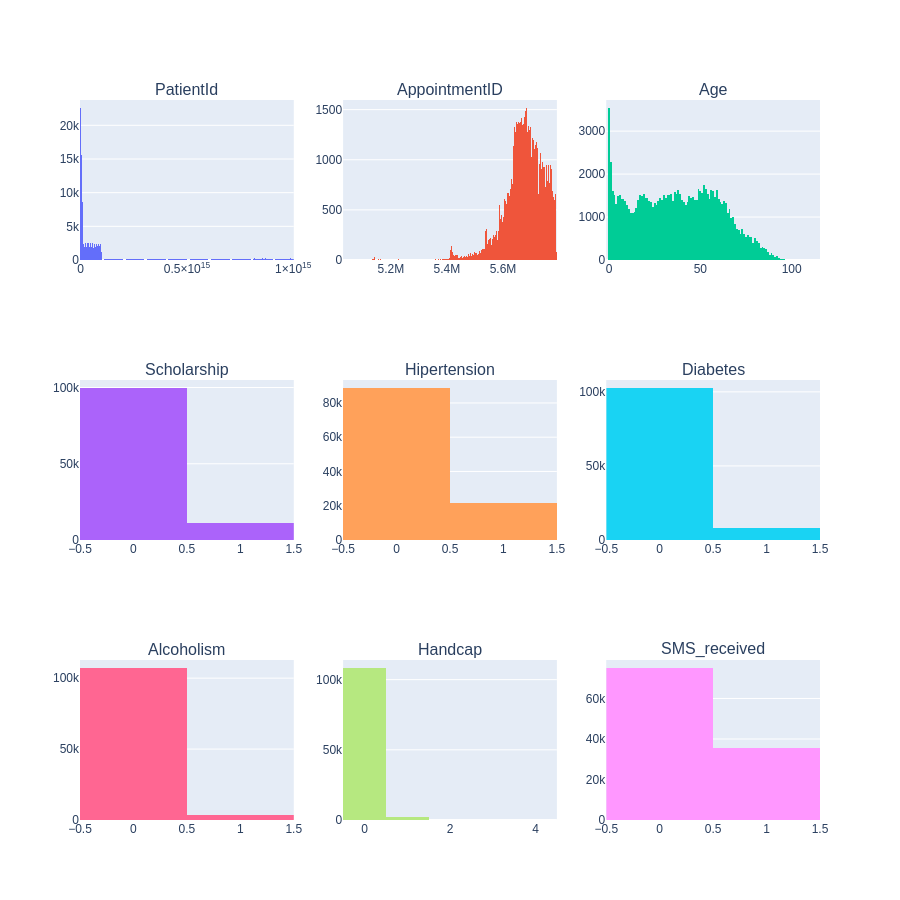

In [80]:
# list of numeric features
numeric_list = list(df.select_dtypes(include=[np.number]).columns.values)
numeric_num = len(numeric_list)
nrows = int(np.floor(np.sqrt(numeric_num)))
ncols = int(np.ceil(numeric_num / nrows))

fig_hist_num = make_subplots(rows=nrows, cols=ncols, subplot_titles=numeric_list)

# scalable histogram
for trace_cnt, feature in enumerate(numeric_list):
    trace = go.Histogram(x=df[feature])
    fig_hist_num.append_trace(trace, trace_cnt // nrows + 1 , trace_cnt % nrows + 1)

fig_hist_num.update_layout(height=300 * nrows, width=300 * ncols, showlegend=False)

# logging figure
experiment.log_figure(figure=fig_hist_num)

fig_hist_num.write_image('images/hist_num.png')
fig_hist_num.show('png')

*Analyze the number of people of each age*

In [81]:
print(f"Unique value in 'Age' feature: {df['Age'].unique()}")

Unique value in 'Age' feature: [ 62  56   8  76  23  39  21  19  30  29  22  28  54  15  50  40  46   4
  13  65  45  51  32  12  61  38  79  18  63  64  85  59  55  71  49  78
  31  58  27   6   2  11   7   0   3   1  69  68  60  67  36  10  35  20
  26  34  33  16  42   5  47  17  41  44  37  24  66  77  81  70  53  75
  73  52  74  43  89  57  14   9  48  83  72  25  80  87  88  84  82  90
  94  86  91  98  92  96  93  95  97 102 115 100  99  -1]


In [82]:
# Remove anomalies
df = df[(df['Age'] >= 0) & (df['Age'] <= 110)]
df['Age'].value_counts()

Age
0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
97       11
98        6
100       4
102       2
99        1
Name: count, Length: 102, dtype: int64

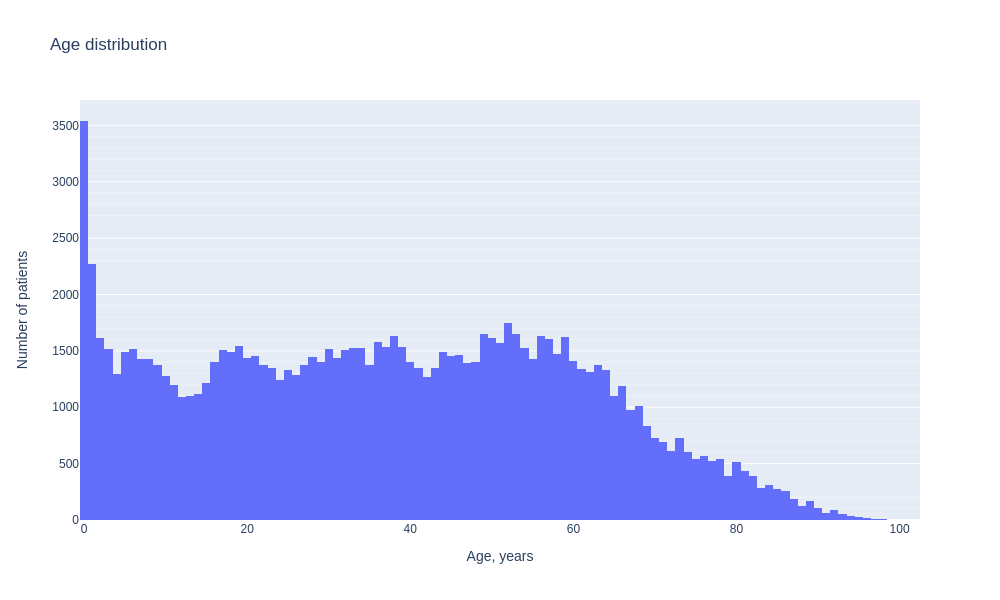

In [83]:
fig_age_hist = go.Figure()
fig_age_hist.add_trace(go.Histogram(x=df['Age'], histfunc='count'))

fig_age_hist.update_layout(showlegend=False, 
                            height=600,
                            width=1000,
                            title="Age distribution")
fig_age_hist.update_yaxes(minor_showgrid=True)
fig_age_hist.layout.xaxis.title.text = 'Age, years'
fig_age_hist.layout.yaxis.title.text = 'Number of patients'

experiment.log_figure(figure=fig_age_hist)
fig_age_hist.write_image('images/age_hist.png')
fig_age_hist.show('png')

### Will do a patient come to the appointment?

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110521 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110521 non-null  float64
 1   AppointmentID   110521 non-null  int64  
 2   Gender          110521 non-null  object 
 3   ScheduledDay    110521 non-null  object 
 4   AppointmentDay  110521 non-null  object 
 5   Age             110521 non-null  int64  
 6   Neighbourhood   110521 non-null  object 
 7   Scholarship     110521 non-null  int64  
 8   Hipertension    110521 non-null  int64  
 9   Diabetes        110521 non-null  int64  
 10  Alcoholism      110521 non-null  int64  
 11  Handcap         110521 non-null  int64  
 12  SMS_received    110521 non-null  int64  
 13  No-show         110521 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 12.6+ MB


#### Categorical features encoding

In [85]:
categorical_columns_names = ['Gender', 'Neighbourhood']
encoded_columns = pd.get_dummies(df, columns=categorical_columns_names)
encoded_columns.drop(['AppointmentID', 'PatientId', 'ScheduledDay', 'AppointmentDay', 'No-show'], axis=1, inplace=True)
encoded_columns.head()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Gender_F,Gender_M,Neighbourhood_AEROPORTO,...,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM
0,62,0,1,0,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,56,0,0,0,0,0,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,62,0,0,0,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,8,0,0,0,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,56,0,1,1,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [86]:
y = df['No-show']
y = y.replace({'No': 0, 'Yes': 1})
y.value_counts(True)

No-show
0    0.798084
1    0.201916
Name: proportion, dtype: float64

#### Data Scaling

In [87]:
from sklearn.preprocessing import MinMaxScaler

In [88]:
scaler = MinMaxScaler()
X = scaler.fit_transform(encoded_columns)
print(X.shape)

(110521, 90)


### The model (this part will be properly learnt further in the course)

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#### Model initializing

In [90]:
logreg = LogisticRegression()

In [91]:
random_state = 42

#### Model learning

In [92]:
logreg.fit(X, y)

/home/teesuhkruta/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

#### Logging of learning parameters

In [93]:
params = {"random_state": random_state,
          "model_type": "logreg"
}

experiment.log_parameters(params)

#### Model prediction

In [94]:
y_pred = logreg.predict(X)

#### Model analysis

In [95]:
accuracy = accuracy_score(y, y_pred)
print(f'Correct result ratio: {accuracy: 6.3f}')

Correct result ratio:  0.798


### Logging metrics

In [96]:
metrics = {"accuracy": accuracy}

In [97]:
experiment.log_metrics(metrics)

In [98]:
experiment.log_confusion_matrix(y.tolist(), y_pred.tolist())

{'web': 'https://www.comet.com/api/asset/download?assetId=237e8cde3666471c8a2209657758c4fd&experimentKey=6cf772251cb64f87bf847c4e8143e2ca',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=237e8cde3666471c8a2209657758c4fd&experimentKey=6cf772251cb64f87bf847c4e8143e2ca',
 'assetId': '237e8cde3666471c8a2209657758c4fd'}

### Numeric features correlation

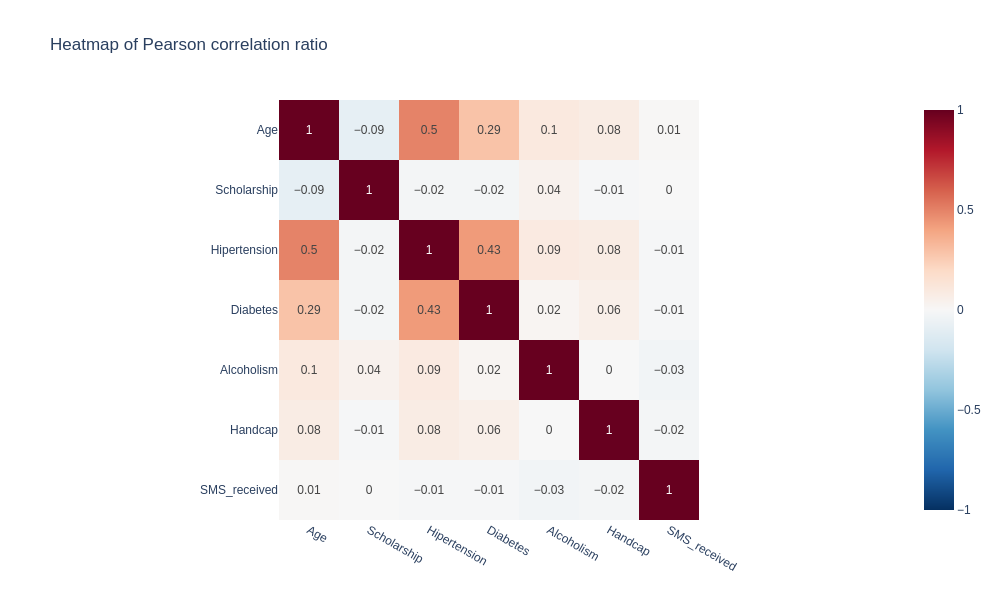

In [99]:
del numeric_list[0:2]
numeric_data = df[numeric_list]

fig_heatmap_corr = px.imshow(
    round(numeric_data.corr(), 2),
    text_auto=True,
    range_color=[-1, 1],
    title='Heatmap of Pearson correlation ratio',
    width=1000,
    height=600,
    color_continuous_scale=px.colors.sequential.RdBu_r
)

experiment.log_figure(figure=fig_heatmap_corr)
fig_heatmap_corr.write_image('images/heatmap_corr.png')
fig_heatmap_corr.show('png')

In [100]:
experiment.display()

In [101]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pime-tuletorn/medical-appointment/6cf772251cb64f87bf847c4e8143e2ca
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.7980836221170637
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     class_weight      : None
COMET INFO:     clip              : False
COMET INFO:     copy              : True
COMET INFO:     dual              : False
COMET INFO:     feature_range     : (0, 1)
COMET INFO:     fit_intercept     : True
COMET INFO:     intercept_scaling : 1
COMET INFO:     l1_ratio          : None
COMET INFO:     max_iter          : 100
COMET INFO:     model_type        : logreg
COMET INFO:     multi_